In [1]:
import os
import sys
import warnings
import scipy.misc
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from skimage.transform import resize
import cv2
import matplotlib
from keras import regularizers
from scipy import ndimage
from keras.models import Model, load_model
from keras.layers import *
from keras import backend as K
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.utils import multi_gpu_model 
import tensorflow as tf
from keras.metrics import binary_crossentropy
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
import random
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

## define constants

In [2]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
TRAIN_IM = './train_im/'
TRAIN_MASK = './train_mask/'
TEST_IM = './test_im/'
TEST_MASK = './test_mask/'
NUM_CLASSES = 4
NUM_GPUS = 8

## build model function

In [4]:
def build_model(width=32, num_classes=4):
    def conv_block(x, width, identity = False):
        x_short = x
        x = Conv2D(width, (3, 3), padding='same') (x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        x = Conv2D(width, (3, 3), padding='same') (x)
        x = BatchNormalization()(x)
        if(identity):
            x = Add()([x, x_short])
            x = LeakyReLU()(x)
            return x
        x_short = Conv2D(width, (3, 3), padding='same') (x_short)
        x_short = BatchNormalization()(x_short)
        x = Add()([x, x_short])
        x = LeakyReLU()(x)
        return x

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, 1))
    activation = 'sigmoid'
    s = Lambda(lambda x: x / 255) (inputs)
    c1 = conv_block(s, width, identity=True)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = conv_block(p1, width*2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = conv_block(p2, width*4)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = conv_block(p3, width*8)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = conv_block(p4, width*16)
    c5_1 = Conv2D(width*16, (3, 3), dilation_rate = 2, padding='same') (c5)
    c5_1 = BatchNormalization()(c5_1)
    c5_1 = LeakyReLU()(c5_1)
    
    c5_2 = Conv2D(width*16, (3, 3), dilation_rate = 4, padding='same') (c5_1)
    c5_2 = BatchNormalization()(c5_2)
    c5_2 = LeakyReLU()(c5_2)
    
    c5_3 = Conv2D(width*16, (3, 3), dilation_rate = 8, padding='same') (c5_2)
    c5_3 = BatchNormalization()(c5_3)
    c5_3 = LeakyReLU()(c5_3)
    
    c5_4 = Conv2D(width*16, (3, 3), dilation_rate = 1, padding='same') (c5_3)
    c5_4 = BatchNormalization()(c5_4)
    c5_4 = LeakyReLU()(c5_4)
    
    c5 = Conv2D(width*16, (1, 1), dilation_rate = 1, padding='same') (c5_4)
    c5 = BatchNormalization()(c5)
    c5 = LeakyReLU()(c5)
    
    #c5 = Add()([c5, c5_1, c5_2, c5_3])
    #c5 = concatenate([c5, c5_1, c5_2, c5_3])

    u6 = Conv2DTranspose(width*8, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = conv_block(u6, width*8)

    u7 = Conv2DTranspose(width*4, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = conv_block(u7, width*4)

    u8 = Conv2DTranspose(width*2, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = conv_block(u8, width*2)

    u9 = Conv2DTranspose(width, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = conv_block(u9, width)

    outputs = Conv2D(num_classes, (1, 1), activation=activation) (c9)
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

## compute weight for each class

In [5]:
def comp_weights():
    back_count = 0
    ec_count = 0
    chrom_count = 0
    nuc_count = 0
    alpha = 1 #used for exponential scaling
    for x in Y_train:
        back_count = back_count + x[:,:,0].sum()
        nuc_count = nuc_count + x[:,:,1].sum() 
        chrom_count = chrom_count + x[:,:,2].sum()
        ec_count = ec_count + x[:,:,3].sum()
    print("number of pixels for background, nuclei, chromosomes, ecDNA: ", 
          back_count, nuc_count, chrom_count, ec_count)
    tot = back_count + nuc_count + chrom_count + ec_count
    back_w = 1
    nuc_w = (nuc_count)**alpha /  (nuc_count)**alpha
    chrom_w = (nuc_count)**alpha /(chrom_count)**alpha
    ec_w = (nuc_count)**alpha / (ec_count)**alpha
    weights = [back_w, nuc_w, chrom_w, ec_w]
    return weights

## Load training and test images

In [3]:
def load_train():
    num_train = len(os.listdir(TRAIN_IM))
    X_train = np.zeros((num_train, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
    Y_train = np.zeros((num_train, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES), dtype=np.bool)
    sys.stdout.flush()
    #load training images
    for count, filename in tqdm(enumerate(os.listdir(TRAIN_IM)), total=num_train):
        img = imread(os.path.join(TRAIN_IM, filename))[:,:,2]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        X_train[count] = img
        name, ext = os.path.splitext(filename)
        mask_name = name + '_mask' + ext    
        mask = imread(os.path.join(TRAIN_MASK, mask_name))[:,:,:NUM_CLASSES]
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        Y_train[count] = mask
    return X_train, Y_train
    
def load_test():
    num_test = len(os.listdir(TEST_IM))
    X_test = np.zeros((num_test, IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
    Y_test = np.zeros((num_test, IMG_HEIGHT, IMG_WIDTH, NUM_CLASSES), dtype=np.bool)
    sys.stdout.flush()
    for count, filename in tqdm(enumerate(os.listdir(TEST_IM)), total=num_test):
        img = imread(os.path.join(TEST_IM, filename))[:,:,2]    
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
        X_test[count] = img
        name, ext = os.path.splitext(filename)
        mask_name = name + '_mask' + ext    
        mask = imread(os.path.join(TEST_MASK, mask_name))[:,:,:NUM_CLASSES]
        mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH))
        Y_test[count] = mask
    return X_test, Y_test
X_train, Y_train = load_train()
X_test, Y_test = load_test()

100%|██████████| 1189/1189 [00:19<00:00, 62.37it/s]


## Combine test and train, shuffle

In [6]:
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
Y = Y[indices]

In [7]:
def weighted_loss(original_loss, weights_list):
    def lossFunc(true, pred):     
        select_class = [K.equal(tf.cast(i, tf.int64), 
                                tf.cast(K.argmax(true, axis=-1), 
                                        tf.int64)) for i in range(len(weights_list))]
        select_class = [K.cast(x, K.floatx()) for x in select_class]
        weights = [sel * w for sel, w in zip(select_class, weights_list)] 
        
        scalar = weights[0]
        for i in range(1, len(weights)):
            scalar = scalar + weights[i]

        loss = original_loss(true,pred)
        loss = loss * scalar
        return loss
    return lossFunc

# Custom loss function
def dice_coef(y_true, y_pred):    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return ((2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.))

def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

def BCE_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred))

def bce_dice(y_true, y_pred):
    return BCE_loss(y_true, y_pred) + dice_loss(y_true, y_pred)

def mIoU(y_true, y_pred):
    prec = []
    for t in np.arange(0.05, 0.1, 0.5):
        score, up_opt = tf.metrics.mean_iou(y_true, tf.to_int32(y_pred > t), num_classes=NUM_CLASSES)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=-1)

print('Weight functions compiled')

Weight functions compiled


In [8]:
model = build_model(num_classes=NUM_CLASSES)
print(model.summary())
if(NUM_GPUS > 1):
    model = multi_gpu_model(model, gpus=4)
weights = comp_weights()
model.compile(optimizer='Adam', loss = weighted_loss(bce_dice, weights), metrics = [mIoU])


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_1[0][0]                   
___________________________________________________________________________________________

number of pixels for background, nuclei, chromosomes, ecDNA:  264513088 39182693 11870701 541457
Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# train model

In [9]:
earlystopper = EarlyStopping(patience=7, verbose=1)
history = model.fit(X, Y, validation_split=0.15, batch_size = 64, 
                             verbose=1, epochs=50, callbacks=[earlystopper])
model_out = model.layers[-2]


Train on 5056 samples, validate on 893 samples
Epoch 1/50
5056/5056 [==============================] - 77s 15ms/step - loss: 0.5424 - mIoU: 0.1871 - val_loss: 0.6685 - val_mIoU: 0.2901
Epoch 2/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.2179 - mIoU: 0.3969 - val_loss: 0.2025 - val_mIoU: 0.4992
Epoch 3/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.1712 - mIoU: 0.5613 - val_loss: 0.1655 - val_mIoU: 0.6093
Epoch 4/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.1368 - mIoU: 0.6442 - val_loss: 0.1231 - val_mIoU: 0.6738
Epoch 5/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.1278 - mIoU: 0.6968 - val_loss: 0.1328 - val_mIoU: 0.7170
Epoch 6/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.1197 - mIoU: 0.7335 - val_loss: 0.1257 - val_mIoU: 0.7478
Epoch 7/50
5056/5056 [==============================] - 54s 11ms/step - loss: 0.1122 - mIoU: 0.7599 - val_loss: 0.1042 - val

# plot training results

dict_keys(['val_loss', 'val_mIoU', 'loss', 'mIoU'])


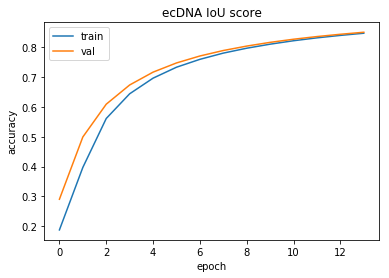

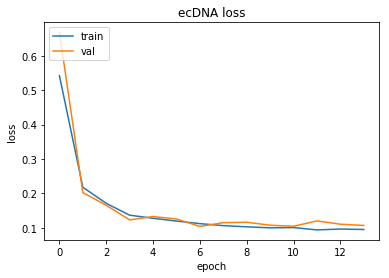

In [10]:
print(history.history.keys())

plt.plot(history.history['mIoU'])
plt.plot(history.history['val_mIoU'])
plt.title('ecDNA IoU score')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('IoU.png')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.title('ecDNA loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()

## Save weights and model

In [11]:
model_out.save('ecDNA_ResUnet_orig.h5')